In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.cluster import KMeans
import PIL.Image
from skimage.util import view_as_blocks
from sklearn.feature_extraction import image
from sklearn.neighbors import NearestNeighbors

In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

In [68]:
class Coloring:
    def __init__(self, img_path):
        rgba_image = PIL.Image.open(img_path)
        rgb_image = rgba_image.convert('RGB')
        self.img = np.array(rgb_image)
        self.img = self.img
        gray = rgb2gray(self.img)
        self.left_actual = self.img[:, :int(self.img.shape[1] / 2), :]
        self.right_actual = self.img[:, int(self.img.shape[1] / 2):, :]
        self.right_actual_shape = self.img[:, int(self.img.shape[1] / 2):, :].shape
        self.left_half = gray[:, :int(self.img.shape[1] / 2)]
        self.right_half = gray[:, int(self.img.shape[1] / 2):]

    def k_means(self, img_part, num_clusters):
        flattened = img_part.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(flattened)
        labels = kmeans.labels_.reshape(img_part.shape[0], img_part.shape[1])
        return labels, kmeans.cluster_centers_

    def naive_paint_left_half(self, num_clusters):
        labels, centers = self.k_means(self.left_actual, num_clusters)
        colored_left = np.zeros(self.left_actual.shape)
        for i in range(labels.shape[0]):
            for j in range(labels.shape[1]):
                label = labels[i][j]
                cluster_center = centers[label]
                colored_left[i][j] = cluster_center
        return colored_left

    def extract_patches_get_knn(self, k):
        pass

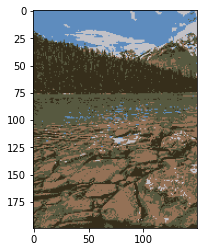

In [70]:
coloring = Coloring('D:\\Study\\Intro_AI\\Coloring_Assignment\\Images\\reduced_300.png')
colored_left = coloring.naive_paint_left_half(5)
plt.imshow(colored_left / 255)
plt.show()

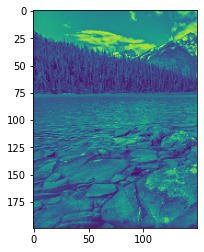

In [5]:
plt.imshow(coloring.left_half/255)
plt.show()

In [6]:
patches = image.extract_patches_2d(coloring.left_half, (3, 3))
patches = patches.reshape((-1, 9))
patches_map = {}
count = 0
for i in range(1, coloring.left_half.shape[0] - 1):
    for j in range(1, coloring.left_half.shape[1] -1):
        patches_map[count] = (i, j)
        count += 1

In [7]:
coloring.right_half[0][0]

198.3267

In [8]:
right_patches = image.extract_patches_2d(coloring.right_half, (3, 3))
right_patches = right_patches.reshape((-1, 9))
right_patches_map = {}
count = 0
for i in range(1, coloring.right_half.shape[0] - 1):
    for j in range(1, coloring.right_half.shape[1] -1):
        right_patches_map[count] = (i, j)
        count += 1

In [9]:
coloring.right_half.shape

(199, 150)

In [10]:
def make_kd_tree(points, dim, i=0):
    if len(points) > 1:
        points.sort(key=lambda x: x[i])
        i = (i + 1) % dim
        half = len(points) >> 1
        return [
            make_kd_tree(points[: half], dim, i),
            make_kd_tree(points[half + 1:], dim, i),
            points[half]
        ]
    elif len(points) == 1:
        return [None, None, points[0]]

In [24]:
# k nearest neighbors
def get_knn(kd_node, point, k, dim, dist_func, return_distances=True, i=0, heap=None):
    import heapq
    is_root = not heap
    if is_root:
        heap = []
    if kd_node is not None:
        dist = dist_func(point, kd_node[2])
        dx = kd_node[2][i] - point[i]
        if len(heap) < k:
            heapq.heappush(heap, (-dist, kd_node[2]))
        elif dist < -heap[0][0]:
            heapq.heappushpop(heap, (-dist, kd_node[2]))
        i = (i + 1) % dim
        # Goes into the left branch, and then the right branch if needed
        for b in [dx < 0] + [dx >= 0] * (dx * dx < -heap[0][0]):
            get_knn(kd_node[b], point, k, dim, dist_func, return_distances, i, heap)
    if is_root:
        neighbors = sorted((-h[0], h[1]) for h in heap)
        return neighbors if return_distances else [n[1] for n in neighbors]

dim = 9

def dist_sq(a, b, dim):
    return sum((a[i] - b[i]) ** 2 for i in range(dim))

def dist_sq_dim(a, b):
    return dist_sq(a, b, dim)

In [25]:
from tqdm import tqdm

In [52]:
import pandas as pd
# pd.DataFrame(right_patches).to_csv("D:\\Study\\Intro_AI\\Coloring_Assignment\\patches/right_patches.csv", index=False)

In [27]:
# df = pd.read_csv('D:\\Study\\Intro_AI\\Coloring_Assignment\\patches/patches.csv')
# print(np.array(df))
# patches

In [28]:
# sc_tree = make_kd_tree(list(patches), 9)

In [29]:
# neighs = []
# for pt in tqdm(right_patches):
#     neighs.append(get_knn(sc_tree, list(pt), 6, dim, dist_sq_dim))

In [30]:
nbrs = NearestNeighbors(n_neighbors=6).fit(patches)


In [31]:
distances, nearest_neighbours = nbrs.kneighbors(right_patches, 6, return_distance=True)


In [32]:
# pt = right_patches[1]
# near_neigh = []
# for pt in tqdm(right_patches):
#     all_dist = {}
#     for i, patch in enumerate(patches):
#         dist = np.linalg.norm(patch-pt)
#         all_dist[i] = dist
#     min_index = min(all_dist, key=all_dist.get)
#     near_neigh.append(min_index)
# print(np.array(near_neigh))

In [33]:
import numpy_indexed as npi

In [34]:
coloring.right_actual_shape

(199, 150, 3)

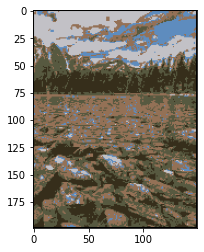

In [35]:
colored_right = np.zeros(coloring.right_actual_shape)
count = 0
for neighbours in nearest_neighbours:
    colors = []
    for neighbour in neighbours:
        colors.append(colored_left[patches_map[neighbour]])
    color = npi.mode(colors, return_indices= False)
    colored_right[right_patches_map[count][0]][right_patches_map[count][1]] = color
    count += 1
plt.imshow(colored_right / 255)
plt.show()


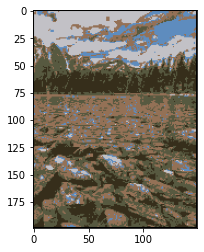

In [37]:
plt.imshow(colored_right / 255)
plt.show()

In [43]:
patches = image.extract_patches_2d(coloring.left_half, (10, 10))
patches = patches.reshape((-1, 100))
patches_map = {}
count = 0
for i in range(1, coloring.left_half.shape[0] - 8):
    for j in range(1, coloring.left_half.shape[1] -8):
        patches_map[count] = (i, j)
        count += 1

print(count)

26790


In [44]:
right_patches = image.extract_patches_2d(coloring.right_half, (10, 10))
right_patches = right_patches.reshape((-1, 100))
right_patches_map = {}
count = 0
for i in range(1, coloring.right_half.shape[0] - 8):
    for j in range(1, coloring.right_half.shape[1] -8):
        right_patches_map[count] = (i, j)
        count += 1

In [45]:
X_train = patches
Y_train = []
for i in range(len(patches_map.keys())):
    Y_train.append(coloring.left_actual[patches_map[i]])
print(len(Y_train))

26790


In [48]:
from Regression import LinearRegression

regressor = LinearRegression(X_train, np.asarray(Y_train), 0.01,
                                 tot_iterations=2000)
regressor.fit_linear_reg_gradient(None)
regressor.get_error()

1.508051369456554
0.7008768284622252
0.4008947891434669
0.28678050513100933
0.24165383825145773
0.22253294441518084
0.21347963755457952
0.20851202566250465
0.2053381045583087
0.20304753066657288
0.20125642264173707
0.19978756283520083
0.19854893923129427
0.19748639829887182
0.19656438799152412
0.19575760249611301
0.19504702213130434
0.19441783057514744
0.19385820036208706
0.19335852028898198
0.19291087093205928
0.19250865198378675
0.19214630887891085
0.19181912753110006
0.1915230773927401
0.1912546896486344
0.19101096144053653
0.19078927967912987
0.19058735979415356
0.19040319601517386
0.19023502065191097
0.1900812704712687
0.18994055872456003
0.1898116517138356
0.1896934490354479
0.18958496682606588
0.18948532347815533
0.18939372740042573
0.1893094664824693


0.1892333885849856

In [54]:
# pd.DataFrame(X_train).to_csv('D:\\Study\\Intro_AI\\Coloring_Assignment\\patches/X_train.csv', index=False)
# pd.DataFrame(np.array(Y_train)).to_csv('D:\\Study\\Intro_AI\\Coloring_Assignment\\patches/Y_train.csv', index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


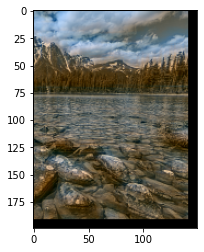

In [49]:
right_predicted = regressor.predict(right_patches)
colored_right = np.zeros(coloring.right_actual_shape)
count = 0
for color in right_predicted:
    colored_right[right_patches_map[count][0]][right_patches_map[count][1]] = color
    count += 1
plt.imshow(colored_right / 255)
plt.show()

Now Neural Networks

In [62]:
import Sample_NN as my_NN

In [59]:
Y_train = np.array(Y_train)

In [60]:
layer_sizes = [100, 10, 10, 1]  # set layer sizes, do not change the size of the first and last layer
num_iters = 1500  # set number of iterations over the training set(also known as epochs in batch gradient descent context)
learning_rate = 0.1  # set learning rate for gradient descent
red_params = my_NN.model(X_train, Y_train[:, 0], layer_sizes, num_iters, learning_rate)  # train the model
red_pred = my_NN.predict(right_patches, red_params)

Cost at iteration 1 = 5869.738192221764

Cost at iteration 2 = 5869.664995320136

Cost at iteration 3 = 5869.5925555174945

Cost at iteration 4 = 5869.520831234767

Cost at iteration 5 = 5869.449793551992

Cost at iteration 6 = 5869.379390232333

Cost at iteration 7 = 5869.309575497452

Cost at iteration 8 = 5869.240315096159

Cost at iteration 9 = 5869.17157043582

Cost at iteration 10 = 5869.1032963814705

Cost at iteration 11 = 5869.0354597255655

Cost at iteration 12 = 5868.968021886108

Cost at iteration 13 = 5868.900952242592

Cost at iteration 14 = 5868.834230939312

Cost at iteration 15 = 5868.767829934266

Cost at iteration 16 = 5868.701714700792

Cost at iteration 17 = 5868.635925486542

Cost at iteration 18 = 5868.5704840742155

Cost at iteration 19 = 5868.505282694779

Cost at iteration 20 = 5868.440206082167

Cost at iteration 21 = 5868.375187189181

Cost at iteration 22 = 5868.310168298896

Cost at iteration 23 = 5868.245121004487

Cost at iteration 24 = 5868.179975487181

In [63]:
green_params = my_NN.model(X_train, Y_train[:, 1], layer_sizes, num_iters, learning_rate)  # train the model
green_pred = my_NN.predict(right_patches, green_params)
blue_params = my_NN.model(X_train, Y_train[:, 2], layer_sizes, num_iters, learning_rate)  # train the model
blue_pred = my_NN.predict(right_patches, blue_params)

Cost at iteration 1 = 5563.761262793813

Cost at iteration 2 = 5563.6730358876885

Cost at iteration 3 = 5563.582357702944

Cost at iteration 4 = 5563.489666423921

Cost at iteration 5 = 5563.395002004972

Cost at iteration 6 = 5563.298321400134

Cost at iteration 7 = 5563.1996147218315

Cost at iteration 8 = 5563.098822354951

Cost at iteration 9 = 5562.9958957866675

Cost at iteration 10 = 5562.890780148209

Cost at iteration 11 = 5562.783429417728

Cost at iteration 12 = 5562.673803796411

Cost at iteration 13 = 5562.561791200968

Cost at iteration 14 = 5562.447269904802

Cost at iteration 15 = 5562.3301279294565

Cost at iteration 16 = 5562.210220270747

Cost at iteration 17 = 5562.087418265845

Cost at iteration 18 = 5561.961625225354

Cost at iteration 19 = 5561.8326779806885

Cost at iteration 20 = 5561.700495473567

Cost at iteration 21 = 5561.56489642162

Cost at iteration 22 = 5561.4257589122

Cost at iteration 23 = 5561.282953021924

Cost at iteration 24 = 5561.136721377293


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


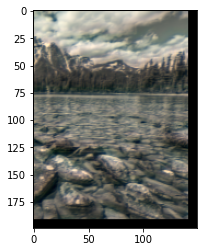

In [67]:
mixed = np.concatenate([red_pred, green_pred, blue_pred], axis= 1)
colored_right = np.zeros(coloring.right_actual_shape)
count = 0
for color in mixed:
    colored_right[right_patches_map[count][0]][right_patches_map[count][1]] = color
    count += 1
plt.imshow(colored_right / 255)
plt.show()

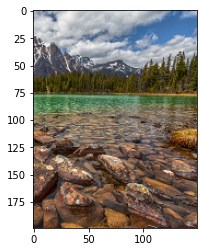

In [72]:
plt.imshow(coloring.right_actual / 255)
plt.show()